# Loading Libraries and Data

First, we import our libraries that we will use for our analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

Next, we read in our training and test data and take a look at the shape as well as take a peek at the data.

In [24]:
train = pd.read_excel('recruiting_zeta-disease_training-data_take-home-challenge (2) (1).xlsx')
print(train.shape)
train.head()

(800, 9)


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [3]:
test = pd.read_excel('recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx')
print(test.shape)
test.head()

(20, 9)


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


# EDA

First, we would like to take a look and see if there are any null values in our training data. We do this below and see there are no nulls.

In [4]:
# Checking for Missing Values
train.isnull().values.any()

False

Next, we would like to take a look at the balance of the target variable. If the data is unbalanced, we should not use accuracy as our evaluation metric. This is done below and we can see that the data is slightly unbalanced. Ideally we would have a 50/50 split of diseased and non-diseased subjects so to deal with this we will optimize on ROC-AUC later on.

In [19]:
# Checking Balance of Target Variable
print(str(round(train['zeta_disease'].mean() * 100,2)) + '% of subjects have zeta disease in training data')

34.38% of subjects have zeta disease in training data


Next, we would like to take a look at the distributions of the data in our training set to see if we see anyting odd. This is done below.

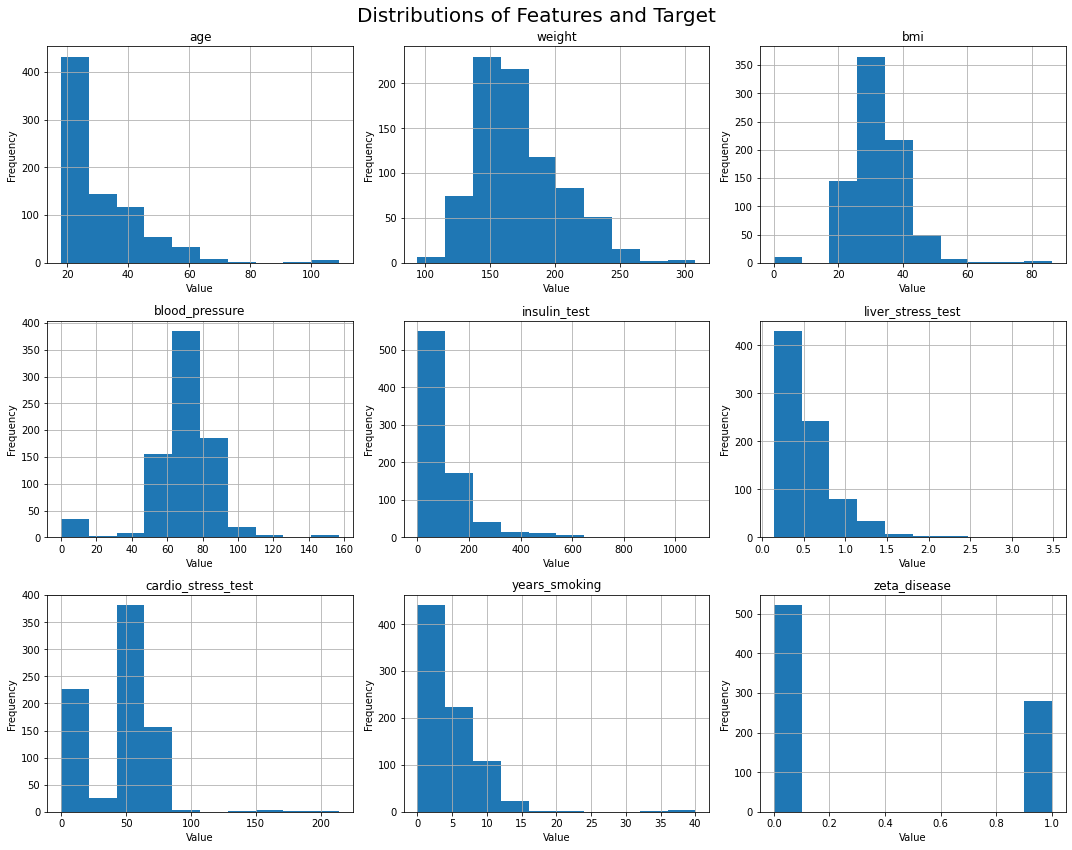

In [6]:
# Defining row and column counters to iterate thru subplots
row = 0
col = 0

# Creating subplot grid and adding title
fig, ax = plt.subplots(3,3, figsize = (15,12))
plt.suptitle('Distributions of Features and Target', fontsize = 20)

# Looping thru each feature in training data
for col_name in train.columns:
    # Plot current feature distribution at current subplot location
    ax[row,col].hist(train[col_name])
    ax[row,col].set_title(col_name)
    ax[row,col].grid()
    ax[row,col].set_xlabel('Value')
    ax[row,col].set_ylabel('Frequency')
    
    # Update subplot location
    if col == 2:
        col = 0
        row += 1
    else:
        col += 1

# Improving Layout spacing
plt.tight_layout()

What jumps out at me from looking at these distributions is that there are a several people with zero blood pressure. It is fairly common knowledge that zero blood pressure is impossible to have for someone so I would like to take a closer look at the subjects that have zero blood pressure. Below I see that there are 35 people with 0 blood pressure. Since this value is impossible I assume that 0 is actually a proxy for missing values.

In [25]:
# Getting subjects with 0 blood pressure
zero_blood_pressure = train[train['blood_pressure'] == 0]
print('Number of subjects with 0 Blood Pressure: ' + str(zero_blood_pressure.shape[0]))
zero_blood_pressure.head()

Number of subjects with 0 Blood Pressure: 35


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
25,28,141,29.8,0,0,0.5638,0,6,0
68,41,167,33.8,0,0,0.9948,0,0,0
74,25,196,27.5,0,0,0.3028,0,2,1
77,29,150,30.0,0,0,0.5468,0,7,1
80,26,165,35.3,0,0,0.1968,0,10,0


Since we only have a small number of subjects in our training data with blood pressure equal to 0, we will drop these subjects. Another reason we do this is because the test data has no values of 0 for blood pressure so we don't want this proxy for a missing value to impact our results. I also suspect zero might be a proxy for missing data in the insulin_test and cardio_stress_test columns but I don't have enough knowledge of what these tests mean to make that assumption. For this reason I will leave them in for now and proceed with caution. Moving forward I might want to consult an expert on what these tests actually mean and if zero is a possible value.

In [26]:
# Removing zero blood pressure subjects from training data
train = train[train['blood_pressure'] > 0]
print(train.shape)

(765, 9)


Below we look at the correlation between our features and our target variable. We can see that weight is the most highly correlated with 0.46 and others have smaller correlations. This might give us a preview as to which features will be most important in our modeling.

In [9]:
# Getting Correlation values with target
correlations = train.corr()['zeta_disease'].sort_values(ascending = False)[1:]
print(correlations)

weight                0.464148
bmi                   0.266471
years_smoking         0.201591
age                   0.200458
liver_stress_test     0.189670
insulin_test          0.138540
blood_pressure        0.127301
cardio_stress_test    0.052650
Name: zeta_disease, dtype: float64


# Modeling

Before we get into modeling, I'd like to make a note that since there are no categorical features in this dataset we will not need to one-hot encode our data. Perhaps in the future I could consult with medical experts or research to create some bucket features based on these numerical features. An example of this would be creating 'healthy', 'overweight', and 'obese' buckets for the BMI feature. If we decided to do this we would need to one hot encode our categorical variables.


Below, we split our training data into our features (X) and target (y). We do the same for our test data except we have null target values so there is no reason to extract the target. I decided to perform MinMax Scaling on our features even though I ended up using random forest as the prediction model. I did this because if we wanted to switch to a non-tree based model that uses gradient descent, we already have the data scaled. The scaled data also will give similar results to non-scaled data when using tree based methods.

In [11]:
# Extracting features and targets
X_train = train.drop('zeta_disease', axis = 1)
y_train = train['zeta_disease']

X_test = test.drop('zeta_disease', axis = 1)

# MinMax Scaling of features
scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

Below we set up our cross validation method. I have chosen a random forest classifier since tree ensembles generally perform well in supervised learning problems. I have set the random_state parameter so our results are reproducible. I have also set up a simiple parameter grid for the number of estimators so we can do a grid search to find which is the best. Because our target is unbalanced, I will optimize on ROC-AUC and I have chosen 5-fold cross validation to build our model to maintain 80/20 splits.

In [12]:
#Cross validation and hyperparameter tuning with random forest
gscv = GridSearchCV(estimator = RandomForestClassifier(random_state = 1),
            param_grid = {'n_estimators': [50,100,500,1000]},
            scoring = 'roc_auc',
            cv = 5)

Below, we are fitting our model to our training data and looking at the best estimator. We can see that having 1000 estimators was the best result in our grid search.

In [13]:
# Fitting model and getting best estimator
gscv.fit(X_train_transformed, y_train)
gscv.best_estimator_

RandomForestClassifier(n_estimators=1000, random_state=1)

When looking at the validation score of the best estimator, we get an ROC-AUC value of around 0.84 which is considered good. 

In [27]:
# Getting Validation Score
gscv.best_score_

0.843780037074825

Before I make predictions, I'd like to take a quick look at the feature importances from our model and compare that with the feature correlations with our target. This is done below and we can see that in general the most important features are the ones with a higher correlation with our target. There are a few exceptions like years_smoking which has a high correlation but a lower feature importance. One potential cause of this could be a collinearity between years_smoking and another feature.

In [14]:
# Getting feature importances
feature_importances = pd.DataFrame(gscv.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                   columns = ['Feature Importance'])

# Joining feature importances with correlation values to compare
importances_and_correlation = feature_importances.merge(correlations, left_index = True, right_index = True)
importances_and_correlation.columns = ['Feature Importance', 'Correlation With Target']
importances_and_correlation.sort_values(['Feature Importance'], ascending = False)

,Feature Importance,Correlation With Target
weight,0.251993,0.464148
bmi,0.158419,0.266471
age,0.138474,0.200458
liver_stress_test,0.127458,0.189670
years_smoking,0.084535,0.201591
blood_pressure,0.084451,0.127301
insulin_test,0.081369,0.138540
cardio_stress_test,0.073301,0.052650


Finally, we let our model make predictions which is done below. We predict 15 subjects have zeta disease and 5 subjects do not have zeta disease.

In [16]:
# Making predictions and showing output
y_predicted = gscv.predict(X_test_transformed)
X_test['zeta_disease_predicted'] = y_predicted
X_test

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease_predicted
0,24,151,39.5,69,72,1.3968,56,4,1
1,27,179,35.5,89,156,1.6608,43,6,1
2,34,147,26.9,76,74,1.6958,53,2,0
3,35,206,32.4,73,127,1.4608,61,6,1
4,60,193,29.8,62,192,1.7798,65,9,1
5,45,120,36.5,108,50,1.2978,54,12,0
6,20,139,38.2,61,77,1.5818,68,3,0
7,23,137,31.2,70,73,1.4168,59,7,0
8,36,195,30.5,59,141,1.4498,59,6,1
9,19,193,25.8,84,66,1.7938,50,3,0
